## Model Selection
This is a continuation of the credit card fraud detection problem, however we are experimenting with classification models instead of anomaly detection models. I split it up into two different notebooks for clarity.

Classification models are fundamentally different from anomaly detection models as they classify new points based on a previously learned profile of positive/normal cases. Thus class imbalance is a huge problem when it comes to these models. We attempt to reduce this by over/undersampling the data to balance the classes. 
There are a few things to do before we go train the models.

To improve our model's accuracy we should:
- remove extreme outliers that will influence our boundaries. (IQR method)
- try undersampling/oversampling to reduce overfitting of normal cases and reinforce learning of fraudulent cases
- consolidate similarly correlated features


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [42]:
# Display the dataframe
def show_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): # Displays code, with meaning cleansup try/catch
        display(df)

# Read and copy data
df_raw = pd.read_csv('data/creditcard.csv')
df = df_raw.copy()
show_all(df.head())

print('Datafrme dimensions: {}'.format(df.shape))


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Datafrme dimensions: (284807, 31)


## Training/Test Split
We used a stratified split to split the data into 80% training and 20% validation set. We ensure that each set has the same percentage of outliers. 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

# Scale features
df[['Amount','Time']] = preprocessing.scale(df[['Amount','Time']])

# Split into X and y
df_y, df_x = df['Class'], df.drop('Class', axis=1)

# Train & Test sets
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=1)

for train_index, test_index in sss.split(df_x, df_y):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_v = df_x.iloc[train_index], df_x.iloc[test_index]
    y_train, y_v = df_y.iloc[train_index], df_y.iloc[test_index]

# Copy training blocks before valid/test split
X_tBlock, y_tBlock = X_v.copy(), y_v.copy()
print()

for valid_index, test2_index in sss2.split(X_v,y_v):
    print("Valid:", valid_index, "Test:", test2_index)
    X_valid, X_test = X_v.iloc[valid_index], X_v.iloc[test2_index]
    y_valid, y_test = y_v.iloc[valid_index], y_v.iloc[test2_index]

print('\nTraining set dimensions: {}'.format(X_train.shape))
print('Validation set dimensions: {}'.format(X_valid.shape))
print('Test set dimensions: {}'.format(X_test.shape))
print('Valid/test block dimensions: {}'.format(X_tBlock.shape))

train_block = pd.concat([X_train,y_train],axis = 1)

Train: [  9341 210529  51525 ... 224660 206178  99525] Test: [ 32255 171386 198944 ... 138758 212696 203581]
Train: [ 10301  84176    390 ...  13070 138218 148701] Test: [180911  84197 166643 ...  70732 169252 150551]
Train: [ 85107 252882  60427 ... 258430  26954  34834] Test: [195123 215525  81858 ... 248741  73553 173385]
Train: [ 47477 173926 233851 ... 106865 184772 135086] Test: [137109 254383 233197 ... 129490 157294 200980]
Train: [260386  93305 221277 ...  77793  80098  33334] Test: [103563 246055 269160 ... 134382 258788  88740]

Valid: [16420  1485 54419 ... 11485  1934 18906] Test: [ 8210 20417 52870 ... 55707 21281 22135]
Valid: [45275 52593 29443 ... 23919 20285  5194] Test: [22037 53930 46883 ... 29619 43887 47605]
Valid: [14599  8440  8935 ... 47365  5253 17354] Test: [12941 27735 34378 ... 39194  2859 37243]
Valid: [28351 16809 12316 ... 17296 27041   894] Test: [46732 39453 11121 ... 34015  2447  6242]
Valid: [21409 39009 11200 ... 53573 54421  1514] Test: [ 9579 1080

## Random Undersampling

In [40]:
# Random undersampling
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = train_block.loc[df['Class'] == 1]
non_fraud_df = train_block.loc[train_block['Class'] == 0][:492]

tmp_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df_undersampled = tmp_df.sample(frac=1, random_state=11)

print(df_undersampled.shape)

(886, 31)


## SMOTE Oversampling

In [5]:
# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
def oversample(xtr,ytr,ref):
    sm = SMOTE(random_state = 42)
    X_res, y_res = sm.fit_resample(xtr, ytr)
    print('Resampled dataset shape %s' % Counter(y_res))
    os_df_x = pd.DataFrame(X_res)
    os_df_y = pd.DataFrame(y_res)
    os_df = pd.concat([os_df_x,os_df_y], axis=1)
    os_df.columns = ref.columns
    #print(os_df)
    return os_df

os_df = oversample(X_train,y_train, df)

Resampled dataset shape Counter({0: 227451, 1: 227451})


## IQR Method
We can process our data such that we remove extreme outliers that could potentially skew our classifier.

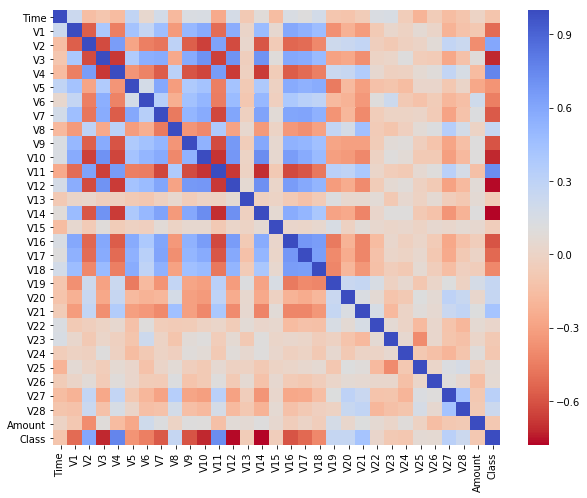

In [6]:
from scipy import stats

corr = np.round(stats.spearmanr(df_undersampled).correlation, 4)
fig, ax = plt.subplots(figsize=(10,8))
g = sns.heatmap(corr, ax=ax,cmap='coolwarm_r')
g.set_yticklabels(df_undersampled.columns, rotation=0)
g.set_xticklabels(df_undersampled.columns, rotation=90)
None

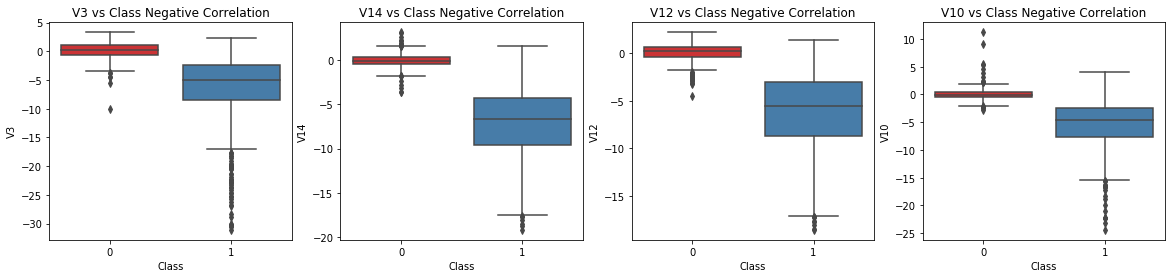

In [7]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V3", data=df_undersampled, palette= "Set1", ax=axes[0])
axes[0].set_title('V3 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df_undersampled, palette="Set1", ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df_undersampled, palette="Set1", ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df_undersampled, palette="Set1", ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

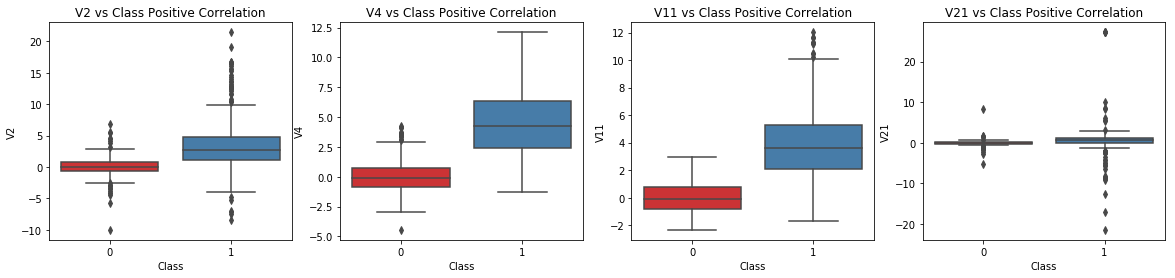

In [8]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V2", data=df_undersampled, palette= "Set1", ax=axes[0])
axes[0].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df_undersampled, palette="Set1", ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V11", data=df_undersampled, palette="Set1", ax=axes[2])
axes[2].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V21", data=df_undersampled, palette="Set1", ax=axes[3])
axes[3].set_title('V21 vs Class Positive Correlation')

plt.show()

In [48]:
def remove_outliers(df,col_name,supress):
    v_fraud = df[col_name].loc[df['Class'] == 1].values
    q25, q75 = np.percentile(v_fraud, 25), np.percentile(v_fraud, 75)
    # Interquartile range
    v_iqr = q75 - q25
    # Calculate cutoffs
    v_cut_off = v_iqr * 1.5
    v_lower, v_upper = q25 - v_cut_off, q75 + v_cut_off
    # Find extreme outliers
    outliers = [x for x in v_fraud if x < v_lower or x > v_upper]
    df = df.drop(df[(df[col_name] > v_upper) | (df[col_name] < v_lower)].index)
    # Output
    if not supress:
        print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
        print('iqr: {}'.format(v_iqr))
        print('Cut Off: {}'.format(v_cut_off))
        print('{} Lower: {}'.format(col_name,v_lower))
        print('{} Upper: {}'.format(col_name, v_upper))
        print('Feature {} Outliers for Fraud Cases: {}'.format(col_name,len(outliers)))
        print('Outliers:{}'.format(outliers))
        print('----' * 44)
    return df

In [49]:
def split(df):
    df_y, df_x = df['Class'], df.drop('Class', axis=1)
    return df_x, df_y

In [50]:
# Remove outliers in these columns
colnames = ['V14','V12','V10','V3','V4','V11','V21','V2']

# Supress outputs for oversampled for readability
for col in colnames:
    df_os_removed = remove_outliers(os_df, col, True)

for col in colnames:
    df_under_removed = remove_outliers(df_undersampled, col, False)

for col in colnames:
    df_removed = remove_outliers(train_block, col, False)

rex,rey = split(df_removed)    
rt = oversample(rex,rey,df)

Quartile 25: -9.576561369479553 | Quartile 75: -4.299187585487335
iqr: 5.277373783992218
Cut Off: 7.9160606759883265
V14 Lower: -17.49262204546788
V14 Upper: 3.6168730905009916
Feature V14 Outliers for Fraud Cases: 6
Outliers:[-18.8220867423816, -17.7216383537133, -18.4937733551053, -18.049997689859396, -17.6206343516773, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.657459534535308 | Quartile 75: -2.99978221723789
iqr: 5.657677317297418
Cut Off: 8.486515975946126
V12 Lower: -17.143975510481432
V12 Upper: 5.486733758708237
Feature V12 Outliers for Fraud Cases: 8
Outliers:[-17.1829184301947, -17.631606313870698, -17.1504052507291, -18.4311310279993, -18.553697009645802, -18.047596570821604, -17.2286622386187, -17.7691434633638]
-------------------------------------------------------------------------------------------------

Quartile 25: -8.427478205509878 | Quartile 75: -2.3347601350331075
iqr: 6.092718070476771
Cut Off: 9.139077105715156
V3 Lower: -17.566555311225034
V3 Upper: 6.8043169706820485
Feature V3 Outliers for Fraud Cases: 48
Outliers:[-22.801237694778198, -28.923755945104, -30.1773174564996, -19.629515251817104, -24.667741248573197, -22.464082746487602, -26.278700586614498, -26.871338779713604, -23.736443410521602, -26.823672913511402, -17.6810718207918, -25.3902293121699, -20.4919522106577, -25.1887729688701, -30.5586968214292, -23.270630523285604, -21.872317364456602, -22.3385905133352, -24.643818777122604, -18.256576111808, -31.103684824581197, -19.0385383213549, -19.7393862972953, -18.572307456296002, -22.209874815521, -17.6810718207918, -19.5750661905691, -21.402916813139104, -30.1773174564996, -30.1773174564996, -23.5539329441267, -21.405835744128, -22.8652284959099, -20.1346128135864, -20.363885973914897, -25.7337337663194, -30.013712485724803, -23.0090029136283, -28.4074244550982, -17.7

## Build Training Sets / Setup Metrics
Here we test a series of different training data.
- Oversampled data 
- Undersampled data
- Oversampled with outliers removed
- Undersampled with outliers removed

In [12]:
X_train_os, y_train_os = split(os_df)
X_train_osr, y_train_osr = split(df_os_removed)

X_train_us, y_train_us = split(df_undersampled)
X_train_usr, y_train_usr = split(df_under_removed)

In [13]:
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def evaluate(actual, predicted):
    c_m = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = c_m.ravel()
    print("Accuracy: ", accuracy_score(actual, predicted))
    print("Confusion Matrix: ", c_m)
    print("F1: ", f1_score(actual, predicted))
    print("False positive rate: ", fp/(fp+tp))
    print("False negative rate: ", fn/(fn+tn))
    print("Precision (positive predictive value): ", tp/(tp+fp))
    print("Recall (true positive rate): ", tp/(tp+fn))
    print()

## Logistic Regression

I first trained logisitic regression with no changes to the parameters and noticed a really good recall. This could potentially be used to build an ensemble classifier. I experimented with GridSearchCV but ended up manually tuning the parameters myself.

In [14]:
# Logistic regression optimizing recall
from sklearn.linear_model import LogisticRegression
lr_recall = LogisticRegression(random_state = 1,solver = 'liblinear', class_weight = 'balanced', penalty = 'l1', C=0.001)
lr_recall.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
pred_log = lr_recall.predict(X_valid)
pred_log_block = lr_recall.predict(X_tBlock)

evaluate(y_valid,pred_log)

lr_rct, lr_prt, lr_tt = precision_recall_curve(y_tBlock,pred_log_block)
#lr_rc, lr_pr, lr_t = precision_recall_curve(y_valid,pred_log)

Accuracy:  0.9779853235490327
Confusion Matrix:  [[27809   623]
 [    4    45]]
F1:  0.12552301255230125
False positive rate:  0.9326347305389222
False negative rate:  0.00014381763923345197
Precision (positive predictive value):  0.06736526946107785
Recall (true positive rate):  0.9183673469387755



In [16]:
# Optimizing F1 score
lr = LogisticRegression(random_state=1, solver='lbfgs', C = 0.0000001)
lr.fit(X_train_osr,y_train_osr)

LogisticRegression(C=1e-07, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
lr_pred_F1 = lr.predict(X_valid)
evaluate(y_valid,lr_pred_F1)

Accuracy:  0.9994733330992591
Confusion Matrix:  [[28427     5]
 [   10    39]]
F1:  0.8387096774193548
False positive rate:  0.11363636363636363
False negative rate:  0.0003516545345852235
Precision (positive predictive value):  0.8863636363636364
Recall (true positive rate):  0.7959183673469388



Seems like were capped at an F1 score of 84. Let's try other models.

## Random Forest

In [18]:
# Since there aren't many parameters to tune, I manually tune them.
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=200, 
                              n_jobs=-1,
                              oob_score=True,max_features = 3)
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [19]:
pred_rf = model2.predict(X_valid)
pred_rf_block = model2.predict(X_tBlock)
evaluate(y_valid, pred_rf)
#rf_rc, rf_pr, rf_t = precision_recall_curve(y_valid, pred_rf)
rf_rct, rf_prt, rf_tt = precision_recall_curve(y_tBlock, pred_rf_block)

Accuracy:  0.9996488887328394
Confusion Matrix:  [[28431     1]
 [    9    40]]
F1:  0.888888888888889
False positive rate:  0.024390243902439025
False negative rate:  0.00031645569620253165
Precision (positive predictive value):  0.975609756097561
Recall (true positive rate):  0.8163265306122449



## XGB

In [20]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(gamma = 0.5, n_jobs = -1, n_estimators = 200)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_valid)
y_score = xgb_model.predict_proba(X_valid)[:,1]

In [21]:
pred_xgb = xgb_model.predict(X_valid)
pred_xgb_tBlock = xgb_model.predict(X_tBlock)
evaluate(y_valid, pred_xgb)
#xgb_rc, xgb_pr, xgb_t = precision_recall_curve(y_valid, pred_xgb)
xgb_rct, xgb_prt, xgb_tt = precision_recall_curve(y_tBlock, pred_xgb_tBlock)

Accuracy:  0.9996488887328394
Confusion Matrix:  [[28430     2]
 [    8    41]]
F1:  0.8913043478260869
False positive rate:  0.046511627906976744
False negative rate:  0.00028131373514311836
Precision (positive predictive value):  0.9534883720930233
Recall (true positive rate):  0.8367346938775511



## Voting Classifier Experimentation

In [22]:
#Voting Classifier
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier (
        estimators = [('lt', lr), ('rf', model2), ('xgb',xgb_model)],
                     voting='soft', weights = [1, 1, 1])
    
voting_model.fit(X_train,y_train)

VotingClassifier(estimators=[('lt', LogisticRegression(C=1e-07, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1, 1])

In [23]:
pred_voting = voting_model.predict(X_valid)
pred_voting_tBlock = voting_model.predict(X_tBlock)
y_score = voting_model.predict_proba(X_valid)[:,1]
evaluate(y_valid, pred_voting)
#vo_rc, vo_pr, vo_t = precision_recall_curve(y_valid, pred_voting)
vo_rct, vo_prt, vo_tt = precision_recall_curve(y_tBlock, pred_voting_tBlock)

Accuracy:  0.9996488887328394
Confusion Matrix:  [[28432     0]
 [   10    39]]
F1:  0.8863636363636364
False positive rate:  0.0
False negative rate:  0.0003515927149989452
Precision (positive predictive value):  1.0
Recall (true positive rate):  0.7959183673469388



## Summary and Data Visualization

In [24]:
def prec_recall_all_models () :
    plt.figure(figsize=(16, 12))
    plt.plot(rf_rct, rf_prt, linewidth = 2)
    plt.plot(xgb_rct, xgb_prt, linewidth = 2)
    plt.plot(lr_rct, lr_prt, linewidth = 2)
    plt.plot(vo_rct, vo_prt, linewidth = 2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve - PR = 0.937 - REC = 0.831 - F1 = 881 ')
    plt.legend(['Rnd', 'Xgb', 'Log', 'Voting'], loc='upper right')
    plt.savefig('7.prec_recc.png')
    plt.show();

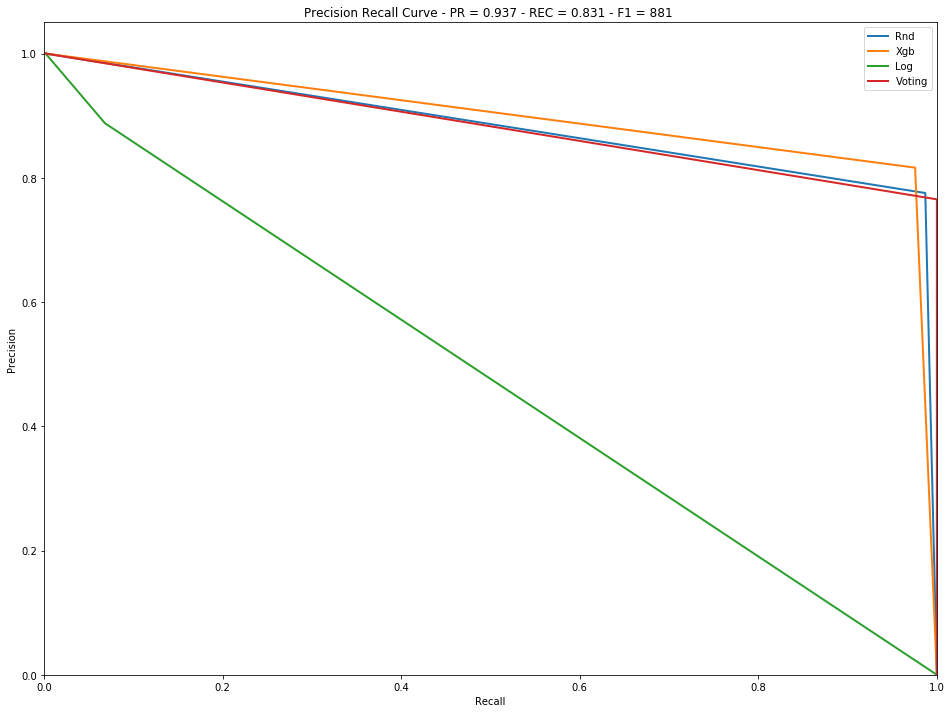

In [25]:
prec_recall_all_models () 

In [38]:
pred_xgb = xgb_model.predict(X_test)
evaluate(y_test,pred_xgb)

Accuracy:  0.9996488887328394
Confusion Matrix:  [[28432     0]
 [   10    39]]
F1:  0.8863636363636364
False positive rate:  0.0
False negative rate:  0.0003515927149989452
Precision (positive predictive value):  1.0
Recall (true positive rate):  0.7959183673469388



Better to choose the model with the lowest false negative rate. It's better to have false alarms than to let fraudulent transactions through. Seems like XGB is the way to go (for now).